In [4]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 1. Visualize

In [14]:
data = scipy.io.loadmat('/Users/poseidon/Documents/NSSP/project_2_nssp/data/S1_E1_A1.mat')

glove_data = data['glove']
selected_joints = [2, 5, 7, 10, 13]  # Joints 3, 6, 8, 11, 14
joint_angles = glove_data[:, selected_joints]

In [15]:
repetition_data = data['rerepetition'].flatten()
print(repetition_data)

[1 1 1 ... 0 0 0]


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


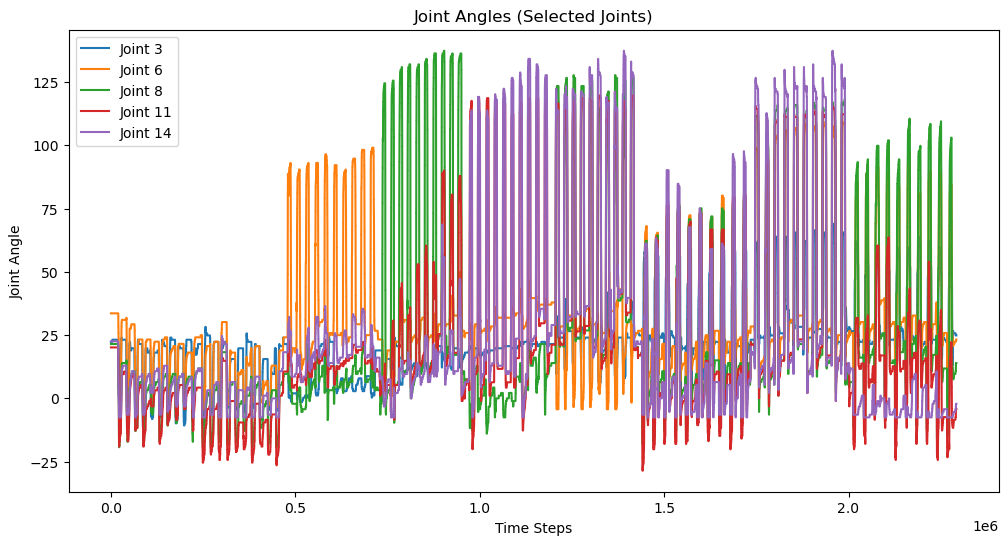

In [16]:
plt.figure(figsize=(12, 6))
for i, joint in enumerate(selected_joints, start=1):
    plt.plot(joint_angles[:, i - 1], label=f'Joint {joint + 1}')
plt.title("Joint Angles (Selected Joints)")
plt.xlabel("Time Steps")
plt.ylabel("Joint Angle")
plt.legend()
plt.show()

The joint angles exhibit consistent distributions, with no extreme outliers.

In [17]:

# Normalize 
scaler = MinMaxScaler()
normalized_joint_angles = scaler.fit_transform(joint_angles)

# Split data based on repetitions
# Training: repetitions 1-4 and 7-10
train_indices = np.where((repetition_data >= 1) & (repetition_data <= 4) | (repetition_data >= 7) & (repetition_data <= 10))[0]
# Testing: repetitions 5-6
test_indices = np.where((repetition_data >= 5) & (repetition_data <= 6))[0]

# Extract training and testing sets
train_data = normalized_joint_angles[train_indices]
test_data = normalized_joint_angles[test_indices]

# validation sets
val_size = 0.2  # 20% of the training data for validation
val_end = int(val_size * train_data.shape[0])

train_set = train_data[:-val_end]
val_set = train_data[-val_end:]


print(f"Training data size: {train_set.shape}")
print(f"Validation data size: {val_set.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (1465799, 5)
Validation data size: (366449, 5)
Test data size: (450400, 5)


/var/folders/v6/k76v8jrj1tj5gl6k8swh19x40000gp/T/ipykernel_18686/303852362.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


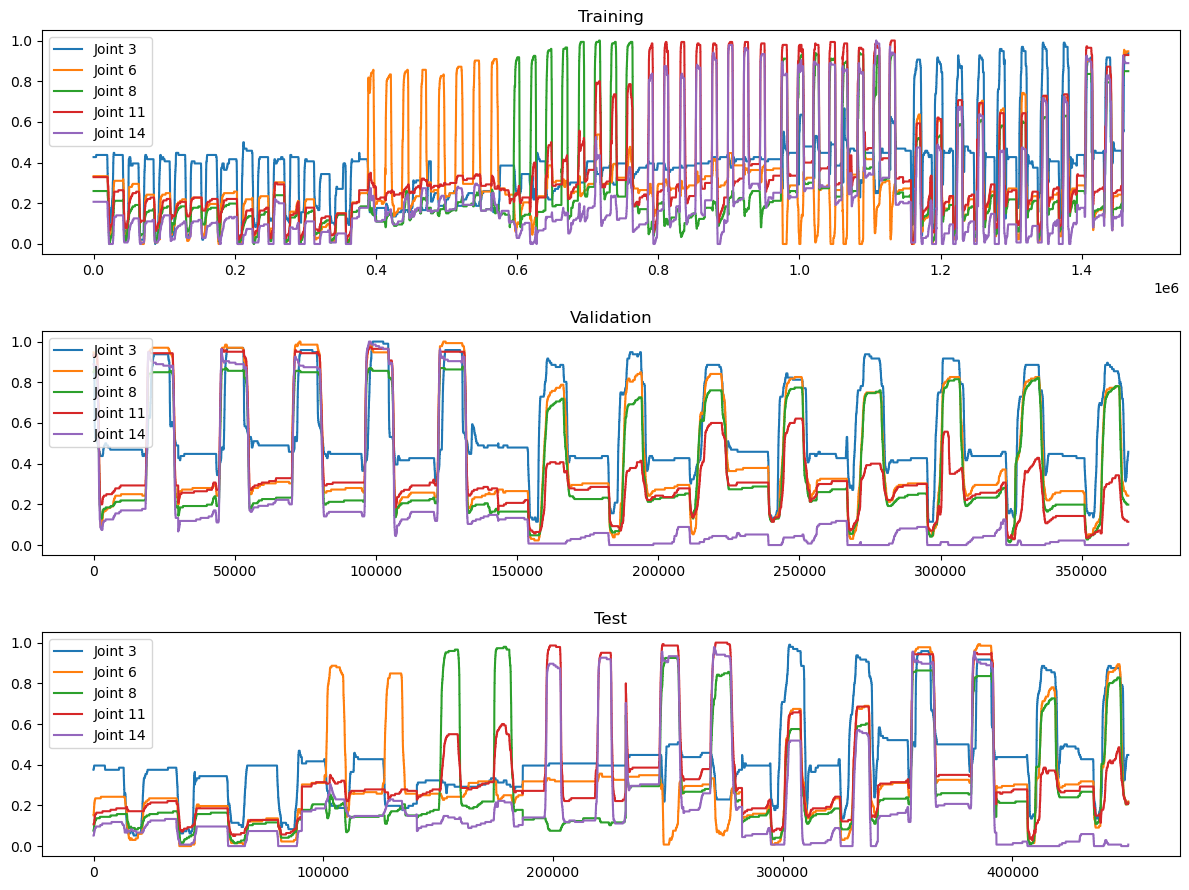

In [18]:
plt.figure(figsize=(12, 9))

# Train 
plt.subplot(3, 1, 1)
for i in range(train_set.shape[1]):
    plt.plot(train_set[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Training")
plt.legend()

# Validation 
plt.subplot(3, 1, 2)
for i in range(val_set.shape[1]):
    plt.plot(val_set[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Validation")
plt.legend()

# Test 
plt.subplot(3, 1, 3)
for i in range(test_data.shape[1]):
    plt.plot(test_data[:, i], label=f'Joint {selected_joints[i] + 1}')
plt.title("Test")
plt.legend()

plt.tight_layout()
plt.show()

A ENLEVER

- plots between 0 and 1 : good normalization 
- Low values (near 0): Represent the joint being in an extended position.
- High values (near 1): Represent the joint being in a flexed  osition.

# 2.Sliding windows

In [19]:
def sliding_window(data, window_width, step):
    """
    Perform sliding window segmentation on the input data.

    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - window_width: number of time steps in each window
    - step: step size for the sliding window

    Returns:
    - segmented_data: numpy array of shape (n_windows, window_width, n_features)
    """
    n_samples, n_features = data.shape
    segmented_data = []

    for start in range(0, n_samples - window_width + 1, step):
        end = start + window_width
        segmented_data.append(data[start:end])

    return np.array(segmented_data)


window_width = 50  
step = 10          


train_windows = sliding_window(train_set, window_width, step)
val_windows = sliding_window(val_set, window_width, step)
test_windows = sliding_window(test_data, window_width, step)


print(f"Training windows shape: {train_windows.shape}")
print(f"Validation windows shape: {val_windows.shape}")
print(f"Test windows shape: {test_windows.shape}")


Training windows shape: (146575, 50, 5)
Validation windows shape: (36640, 50, 5)
Test windows shape: (45036, 50, 5)


A JUSTIFER LE WW and SS !!!!

# 3.Extract set features

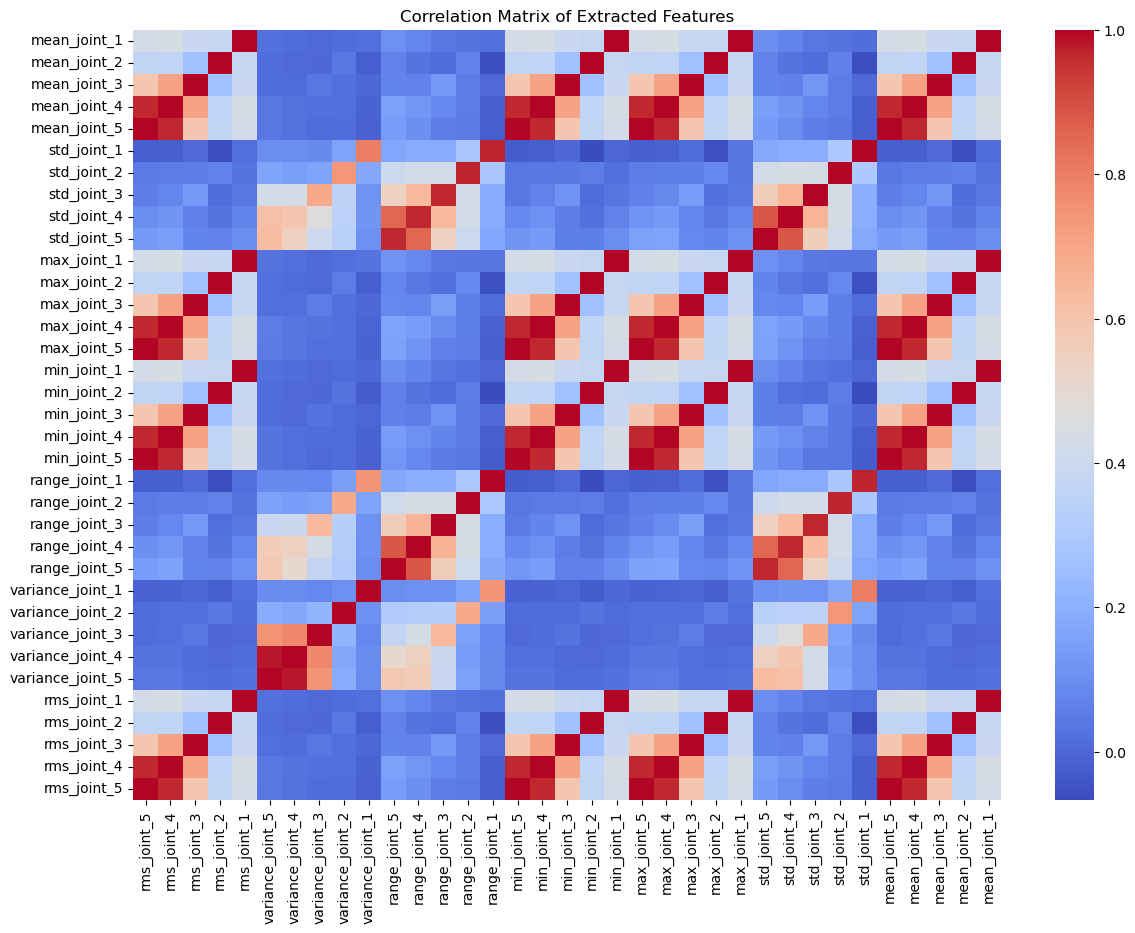

In [20]:
def extract_features(data_windows):
    """
    Extract statistical and signal-processing features from sliding window data.

    Parameters:
    - data_windows: numpy array of shape (n_windows, window_width, n_features)

    Returns:
    - features: numpy array of extracted features (n_windows, n_features * n_extracted_features)
    """
    features = []
    for window in data_windows:
        # Statistical features
        mean = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        max_val = np.max(window, axis=0)
        min_val = np.min(window, axis=0)
        range_val = max_val - min_val
        variance = np.var(window, axis=0)
        rms = np.sqrt(np.mean(window**2, axis=0))

        window_features = np.hstack([mean, std, max_val, min_val, range_val, variance, rms])
        features.append(window_features)

    return np.array(features)

# Extract features
train_features = extract_features(train_windows)
val_features = extract_features(val_windows)
test_features = extract_features(test_windows)

# Normalize the features
scaler = MinMaxScaler()
train_features_normalized = scaler.fit_transform(train_features)

# Create a DataFrame for the correlation analysis
feature_labels = ['mean', 'std', 'max', 'min', 'range', 'variance', 'rms']
joint_labels = [f'joint_{i+1}' for i in range(train_windows.shape[2])]
columns = [f'{label}_{joint}' for label in feature_labels for joint in joint_labels]

train_features_df = pd.DataFrame(train_features_normalized, columns=columns)


# Correlation matrix
correlation_matrix = train_features_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.gca().invert_xaxis() 

plt.title("Correlation Matrix of Extracted Features")
plt.show()


#### Extracted Features:
We computed the following features from each sliding window:
- **Mean**: Average value of joint angles within the window.
- **Standard Deviation (std)**: Variation in joint angles.
- **Maximum (max)** and **Minimum (min)**: Peak values of joint angles.
- **Range**: Difference between maximum and minimum joint angles.
- **Variance**: Measure of joint angle variability.
- **Root Mean Square (RMS)**: A measure reflecting the magnitude of joint angle movements.

#### Normalization:
We applied Min-Max Scaling to normalize all extracted features into the range `[0, 1]` for better interpretability and to ensure features are on a comparable scale.

#### Correlation Analysis:
- **High Correlation**:
   - Features like **Mean** and **RMS** for the same joints exhibit high correlation because RMS incorporates the magnitude of joint angle movements, similar to the Mean.
   - **Variance** and **Standard Deviation (std)** for the same joints are highly correlated due to their mathematical relationship.
   - Features such as **Maximum (max)** and **Minimum (min)** for corresponding joints also show strong correlation with **Range**.

- **Low or No Correlation**:
   - Cross-joint features, such as **Mean_joint_1** and **Max_joint_4**, exhibit very low correlation, as the joint angles may behave independently.
   - Variance or RMS for unrelated joints also shows no significant correlation.

- **Feature Redundancy**:
   - Features such as **Variance** and **Standard Deviation (std)** are redundant since they provide similar information about the variability of joint angles.
   - **Mean** and **RMS** can also be considered redundant for the same joints due to their strong correlation.

#### Observations:
- High correlations between features like **Mean**, **RMS**, and **Variance** suggest redundancy in the dataset. Dimensionality reduction techniques (e.g., PCA) can be applied to mitigate redundancy.
- Low correlation between different joints indicates that joint angles are not strongly interdependent, which can be leveraged to train independent models for each joint.
- The diagonal patterns in the correlation matrix validate that features within the same joints are inherently related, while cross-joint relationships remain weak.


# 4.SVM

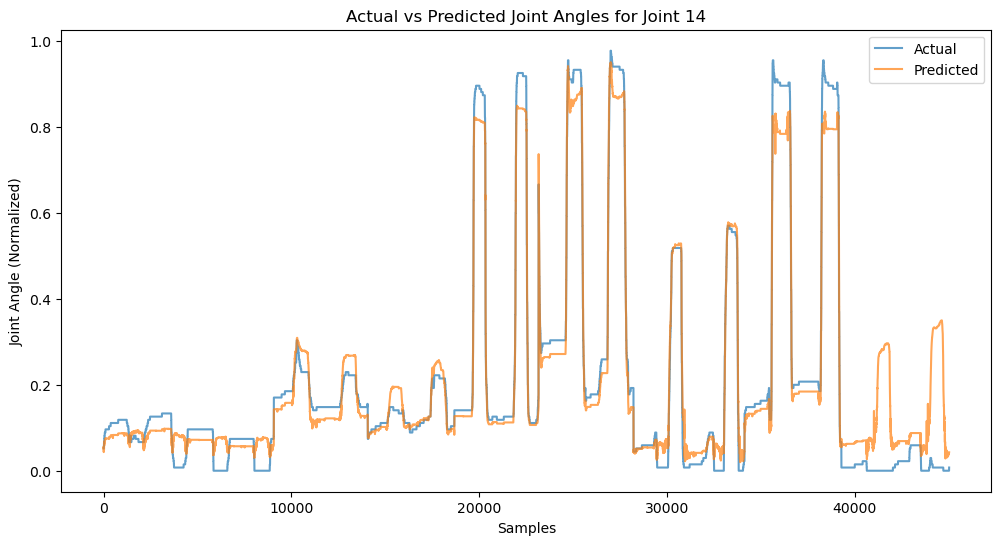

Joint 3: MSE = 0.0029, R² = 0.9258
Joint 6: MSE = 0.0060, R² = 0.8854
Joint 8: MSE = 0.0033, R² = 0.9489
Joint 11: MSE = 0.0025, R² = 0.9581
Joint 14: MSE = 0.0046, R² = 0.9342


In [25]:
# Correct the target variable alignment to match sliding windows
train_targets = train_set[window_width - 1::step] 
val_targets = val_set[window_width - 1::step]
test_targets = test_data[window_width - 1::step]

svr_models = []
test_predictions = []
mse_scores = []
r2_scores = []

# Train SVR models for each joint 
for joint in range(train_targets.shape[1]):
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(train_features_normalized, train_targets[:, joint])
    svr_models.append(svr)

    predictions = svr.predict(scaler.transform(test_features))
    test_predictions.append(predictions)

    mse = mean_squared_error(test_targets[:, joint], predictions)
    r2 = r2_score(test_targets[:, joint], predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)


test_predictions = np.array(test_predictions).T


plt.figure(figsize=(12, 6))
joint_idx = 4  # Index for the joint to visualize [0,4]
plt.plot(test_targets[:, joint_idx], label="Actual", alpha=0.7)
plt.plot(test_predictions[:, joint_idx], label="Predicted", alpha=0.7)
plt.title(f"Actual vs Predicted Joint Angles for Joint {selected_joints[joint_idx] + 1}")
plt.xlabel("Samples")
plt.ylabel("Joint Angle (Normalized)")
plt.legend()
plt.show()

for i, joint in enumerate(selected_joints):
    print(f"Joint {joint + 1}: MSE = {mse_scores[i]:.4f}, R² = {r2_scores[i]:.4f}")

- **Model**: Support Vector Regression (SVR)  
- **Training**: Separate SVR models were trained for each joint to predict joint angles based on extracted features.  
- **Evaluation**: Performance was measured using:
  - **Mean Squared Error (MSE)**: Lower values indicate better predictions.
  - **R² Score**: Measures how well predictions match actual values (closer to 1 indicates better performance).

#### Results:
- **Performance Metrics**:
   - **Joint 3**: MSE = 0.0029, R² = 0.9258  
   - **Joint 6**: MSE = 0.0060, R² = 0.8854  
   - **Joint 8**: MSE = 0.0033, R² = 0.9489  
   - **Joint 11**: MSE = 0.0025, R² = 0.9581  
   - **Joint 14**: MSE = 0.0046, R² = 0.9342  

#### Observations:
- **High Accuracy**: Joints **8** and **11** showed the best performance with **R² values of 0.9489** and **0.9581**, respectively, indicating the SVR model effectively captured the variability in joint angles with minimal error.  
- **Moderate Performance**: Joint **6** had a relatively higher MSE (**0.0060**) and lower R² (**0.8854**) compared to the others, suggesting a more challenging joint with slightly less predictable behavior.  


# 5.Metrics

   Joint       MSE        R²
0      3  0.002898  0.925815
1      6  0.005980  0.885408
2      8  0.003268  0.948925
3     11  0.002487  0.958061
4     14  0.004582  0.934202


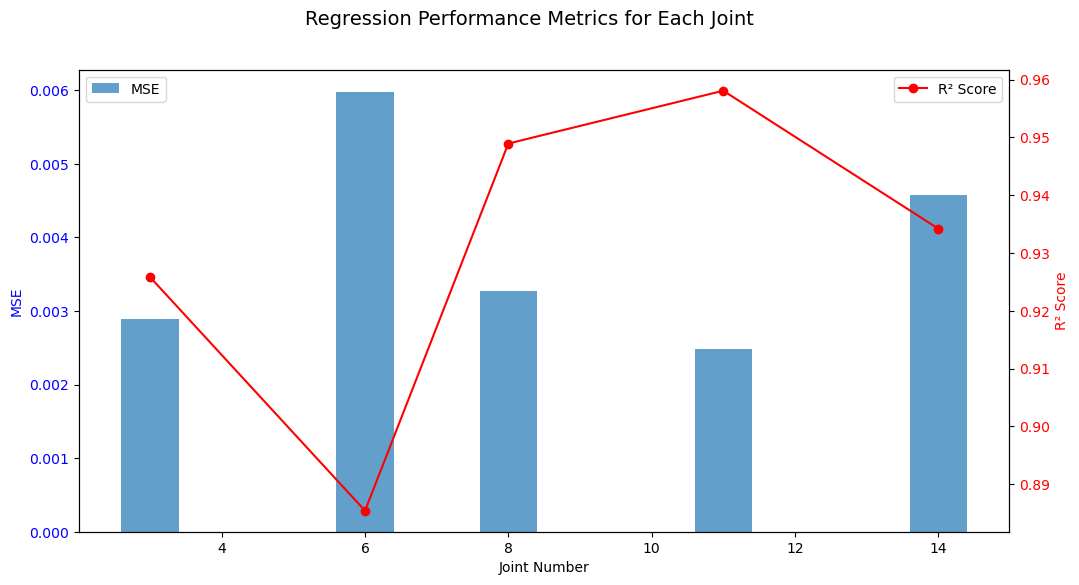

In [26]:
performance_metrics = []
for i, joint in enumerate(selected_joints):
    performance_metrics.append({
        "Joint": joint + 1,
        "MSE": mse_scores[i],
        "R²": r2_scores[i]
    })

metrics_df = pd.DataFrame(performance_metrics)
print(metrics_df)


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSE
ax1.bar(metrics_df["Joint"], metrics_df["MSE"], alpha=0.7, label="MSE")
ax1.set_xlabel("Joint Number")
ax1.set_ylabel("MSE", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Plot R² scores (secondary axis)
ax2 = ax1.twinx()
ax2.plot(metrics_df["Joint"], metrics_df["R²"], color="red", marker="o", label="R² Score")
ax2.set_ylabel("R² Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.suptitle("Regression Performance Metrics for Each Joint", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


#### Metrics Used:
1. **Mean Squared Error**: Represents the average squared difference between predicted and actual joint angles. Penalizes larger errors more heavily.  
2. **R² Score**: Indicates the proportion of variance in the joint angles explained by the regression model. A value closer to 1 implies better predictive performance.

#### Results:
- **Joint 3**: MSE = **0.0029**, R² = **0.9258**  
- **Joint 6**: MSE = **0.0060**, R² = **0.8854**  
- **Joint 8**: MSE = **0.0033**, R² = **0.9489**  
- **Joint 11**: MSE = **0.0025**, R² = **0.9581**  
- **Joint 14**: MSE = **0.0046**, R² = **0.9342**  

#### Observations:
1. **MSE**:
   - The lowest **MSE** is observed for **Joint 11** (0.0025), indicating highly accurate predictions with minimal errors.
   - The highest **MSE** is observed for **Joint 6** (0.0060), suggesting that this joint's angles are harder to predict due to higher variability or noise.

2. **R² Score**:
   - The highest **R²** is achieved for **Joint 11** (0.9581), showing that the model explains nearly 96% of the variance in joint angles for this joint.
   - The lowest **R²** is for **Joint 6** (0.8854), reflecting moderate performance with some unexplained variability.

#### Suitability of Metrics:
- **MSE** is suitable because precise joint angle predictions are critical for robotic hand control, and larger errors must be penalized more heavily.
- **R² Score** is useful for interpreting how well the model captures the variability in joint angles. High R² values across most joints validate the model's effectiveness.

#### Conclusion:
- The SVR model demonstrates strong predictive performance overall, particularly for **Joints 11, 8**, and **14**, which have low MSE and high R² scores.
- **Joint 6** shows relatively lower performance, suggesting potential improvements through feature refinement or model tuning.

# 6.SVM performance

#### Observations:
- The SVR model demonstrates excellent performance for **Joint 11**, achieving the lowest MSE (0.0025) and the highest R² score (0.9581), indicating precise predictions and strong variance capture.
- Moderate performance is observed for **Joint 6**, with the highest MSE (0.0060) and lowest R² score (0.8854), suggesting challenges in predicting this joint's angles accurately.
- Overall, the model performs consistently well across the remaining joints (**3, 8, and 14**) with relatively low MSE values and high R² scores.

#### Possible Explanations for Differences:
1. **Joint Variability**:  
   - Joints like **6** may have more erratic or complex movements, leading to higher prediction errors.  
   - Joints like **11** likely exhibit smoother and more predictable movement patterns, making them easier to model.
   
2. **Feature Importance**:  
   - Redundant or less informative features may affect model accuracy for certain joints.  
   - Feature correlations (as seen earlier) may benefit some joints while adding noise to others.  

3. **Model Limitations**:  
   - SVR may struggle with joints exhibiting nonlinear or irregular behaviors, leading to slightly lower performance.  

#### Conclusion:
- The SVR model performs exceptionally well for joints with consistent and smooth movement patterns, as seen for **Joint 11** and **Joint 8**.
- Joints with higher variability, such as **Joint 6**, show moderate performance, indicating room for improvement through advanced feature engineering or more complex models (e.g., deep learning).
- Overall, SVR proves to be a reliable approach for predicting joint angles, achieving **high accuracy** and explaining most of the variance in the joint angle movements.